# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

In [1]:
# Load All libraries
import pandas as pd
import numpy as np
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
from scipy.io import arff
import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sagemaker import image_uris
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Load combined_csv_v1.csv and combined_csv_v2.csv to dataframe

In [3]:
csv_v1 = pd.read_csv(f'combined_csv_v1.csv', encoding='utf-8', low_memory=False)

# move target column to the left
column_names = csv_v1.columns.tolist()
column_names = [column_names[1]] + column_names[:1] + column_names[2:]
csv_v1 = csv_v1[column_names]

csv_v1['target'] = csv_v1['target'].astype(int)
boolean_columns = [col for col in csv_v1.columns if csv_v1[col].dtype == bool]
csv_v1[boolean_columns] = csv_v1[boolean_columns].astype(int)

csv_v1.head(5)

target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0       0    1464.0          1          0          0        0        0   
1       1    1464.0          1          0          0        0        0   
2       1    1464.0          1          0          0        0        0   
3       0    1464.0          1          0          0        0        0   
4       0    1464.0          1          0          0        0        0   

   Month_4  Month_5  Month_6  ...  Origin_PHX  Origin_SFO  Dest_CLT  Dest_DEN  \
0        0        0        1  ...           0           0         0         0   
1        0        0        1  ...           0           0         0         0   
2        0        0        1  ...           0           0         0         0   
3        0        0        1  ...           0           0         0         0   
4        0        0        1  ...           0           0         0         0   

   Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  
0         0         0         0         0         0         1  
1         0         0         0         0         0         1  
2         0         0         0         0         0         1  
3         0         0         0         0         0         1  
4         0         0         0         0         0         1  

[5 rows x 72 columns]

In [5]:
csv_v2 = pd.read_csv(f'combined_csv_v2.csv', encoding='utf-8', low_memory=False)
csv_v2['target'] = csv_v2['target'].astype(int)
boolean_columns = [col for col in csv_v2.columns if csv_v2[col].dtype == bool]
csv_v2[boolean_columns] = csv_v2[boolean_columns].astype(int)
csv_v2.head(5)

target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0       0    1464.0            15      52       0   284.0      38       0   
1       1    1464.0            17      41       0   282.0      57       0   
2       1    1464.0            17      47      18   263.0      63       0   
3       0    1464.0            16      21       0   277.0      53       0   
4       0    1464.0            15      51       0   283.0      67       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   176.0     0.0  ...           0         0         0         0         0   
1   169.0     0.0  ...           0         0         0         0         0   
2   150.0     0.0  ...           0         0         0         0         0   
3   188.0     0.0  ...           0         0         0         0         0   
4   153.0     0.0  ...           0         0         0         0         0   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_True  
0         0         0         0         1                0  
1         0         0         0         1                0  
2         0         0         0         1                0  
3         0         0         0         1                0  
4         0         0         0         1                0  

[5 rows x 86 columns]

## Create Commonn function

In [6]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

def upload_data_s3(filename, folder, dataframe, i_bucket, i_prefix, i_version):
    s3_resource = boto3.Session().resource('s3')
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(i_bucket).Object(os.path.join(i_prefix, folder, filename)).put(Body=csv_buffer.getvalue())
    print(f"Uploaded {folder} to s3 {i_version}")

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

Step 2.1 Split data into training, validation and testing sets (70% - 15% - 15%).

In [8]:
# For combined_csv_v1
train_v1, test_and_validate_v1 = train_test_split(csv_v1, test_size=0.3, random_state=42, stratify=csv_v1['target'])
test_v1, validate_v1 = train_test_split(test_and_validate_v1, test_size=0.5, random_state=42, stratify=test_and_validate_v1['target'])
print("combined_csv_v1.csv train, test and validate data")
print("train_v1.shape")
print(train_v1.shape)
print("test_v1.shape")
print(test_v1.shape)
print("validate_v1.shape")
print(validate_v1.shape)
print("train target")
print(train_v1['target'].value_counts())
print("test target")
print(test_v1['target'].value_counts())
print("validate target")
print(validate_v1['target'].value_counts())

combined_csv_v1.csv train, test and validate data
train_v1.shape
(1144913, 72)
test_v1.shape
(245338, 72)
validate_v1.shape
(245339, 72)
train target
target
0    904581
1    240332
Name: count, dtype: int64
test target
target
0    193838
1     51500
Name: count, dtype: int64
validate target
target
0    193839
1     51500
Name: count, dtype: int64


Step 2.2 Use linear learner estimator to build a classifcation model.

In [9]:
# Upload splited data to S3 for Modeling
sess = sagemaker.Session()

region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sess.default_bucket()
prefix = "sagemaker/linear-learner"

train_file_v1='combined_csv_v1_train.csv'
test_file_v1='combined_csv_v1_test.csv'
validate_file_v1='combined_csv_v1_validate.csv'

upload_data_s3(train_file_v1, 'train', train_v1, bucket, prefix, "v1")
upload_data_s3(test_file_v1, 'test', test_v1, bucket, prefix, "v1")
upload_data_s3(validate_file_v1, 'validate', validate_v1, bucket, prefix, "v1")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Uploaded train to s3 v1
Uploaded test to s3 v1
Uploaded validate to s3 v1


In [10]:
# linear learner classifcation
container_v1 = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
s3_output_location_v1="s3://{}/{}/output-linear-v1/".format(bucket,prefix)
linear_classifier_v1 = sagemaker.estimator.Estimator(container_v1,
                                            sagemaker.get_execution_role(),
                                            instance_count=1,
                                            instance_type='ml.m4.xlarge',
                                            output_path=s3_output_location_v1,
                                            sagemaker_session=sagemaker.Session())
linear_classifier_v1.set_hyperparameters(predictor_type="regressor")
train_input_v1 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file_v1),
    content_type='text/csv')
validate_input_v1 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file_v1),
    content_type='text/csv')
data_channels = {'train': train_input_v1, 'validation': validate_input_v1}
linear_classifier_v1.fit(inputs=data_channels, logs=False)
print('Done')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-03-00-45-19-462



2023-11-03 00:45:19 Starting - Starting the training job....
2023-11-03 00:45:45 Starting - Preparing the instances for training.................
2023-11-03 00:47:16 Downloading - Downloading input data.......
2023-11-03 00:47:56 Training - Downloading the training image...........
2023-11-03 00:48:57 Training - Training image download completed. Training in progress.......................................................
2023-11-03 00:53:38 Uploading - Uploading generated training model..
2023-11-03 00:53:49 Completed - Training job completed
Done


Step 2.3 Host the model on another instance

In [11]:
linear_predictor_v1 = linear_classifier_v1.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: linear-learner-2023-11-03-00-53-54-469
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-11-03-00-53-54-469
INFO:sagemaker:Creating endpoint with name linear-learner-2023-11-03-00-53-54-469


---------!

In [16]:
row = test_v1.iloc[0:1,1:]
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()

Step 2.4 Perform batch transform to evaluate the model on testing data

Step 2.5 Report the performance metrics that you see better test the model performance 

In [17]:
# Write the final comments here and turn the cell type into markdown


# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

Step 3.1. Split data into training, validation and testing sets (70% - 15% - 15%).

In [18]:
# For combined_csv_v1
train_v1, test_and_validate_v1 = train_test_split(csv_v1, test_size=0.3, random_state=42, stratify=csv_v1['target'])
test_v1, validate_v1 = train_test_split(test_and_validate_v1, test_size=0.5, random_state=42, stratify=test_and_validate_v1['target'])
print("combined_csv_v1.csv train, test and validate data")
print("train_v1.shape")
print(train_v1.shape)
print("test_v1.shape")
print(test_v1.shape)
print("validate_v1.shape")
print(validate_v1.shape)
print("train target")
print(train_v1['target'].value_counts())
print("test target")
print(test_v1['target'].value_counts())
print("validate target")
print(validate_v1['target'].value_counts())

combined_csv_v1.csv train, test and validate data
train_v1.shape
(1144913, 72)
test_v1.shape
(245338, 72)
validate_v1.shape
(245339, 72)
train target
target
0    904581
1    240332
Name: count, dtype: int64
test target
target
0    193838
1     51500
Name: count, dtype: int64
validate target
target
0    193839
1     51500
Name: count, dtype: int64


Step 3.2. Use xgboost estimator to build a classifcation model.

In [19]:
sess = sagemaker.Session()
region = boto3.Session().region_name
bucket = sess.default_bucket()
prefix = "sagemaker/xgboost-learner"

s3_resource = boto3.Session().resource('s3')

train_file_v1='combined_csv_v1_train.csv'
test_file_v1='combined_csv_v1_test.csv'
validate_file_v1='combined_csv_v1_validate.csv'


upload_data_s3(train_file_v1, 'train', train_v1, bucket, prefix, "v1")
upload_data_s3(test_file_v1, 'test', test_v1, bucket, prefix, "v1")
upload_data_s3(validate_file_v1, 'validate', validate_v1, bucket, prefix, "v1")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Uploaded train to s3 v1


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Uploaded test to s3 v1
Uploaded validate to s3 v1


In [20]:
container_v1 = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location_v1="s3://{}/{}/output-xgboost-v1/".format(bucket,prefix)
xgboost_classifier_v1 = sagemaker.estimator.Estimator(container_v1,
                                            sagemaker.get_execution_role(),
                                            instance_count=1,
                                            instance_type='ml.m4.xlarge',
                                            output_path=s3_output_location_v1,
                                            hyperparameters=hyperparams,
                                            sagemaker_session=sagemaker.Session())

train_trainingInput_v1 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file_v1),
    content_type='text/csv')

validate_trainingInput_v1 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file_v1),
    content_type='text/csv')

data_channels = {'train': train_trainingInput_v1, 'validation': validate_trainingInput_v1}

xgboost_classifier_v1.fit(inputs=data_channels, logs=False)

print('Done Setting')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-03-01-00-27-682



2023-11-03 01:00:28 Starting - Starting the training job....
2023-11-03 01:00:54 Starting - Preparing the instances for training.................
2023-11-03 01:02:28 Downloading - Downloading input data.......
2023-11-03 01:03:09 Training - Downloading the training image........
2023-11-03 01:03:50 Training - Training image download completed. Training in progress.....................
2023-11-03 01:05:36 Uploading - Uploading generated training model.
2023-11-03 01:05:47 Completed - Training job completed
Done Setting


Step 3.3. Host the model on another instance

In [22]:
xgb_predictor_v1 = xgboost_classifier_v1.deploy(initial_instance_count=1, serializer = sagemaker.serializers.CSVSerializer(), instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-03-01-09-00-847
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-03-01-09-00-847
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-03-01-09-00-847


------!

In [23]:
row = test_v1.iloc[0:1,1:]
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
xgb_predictor_v1.predict(test_row)

b'0.13721758127212524'

Step 3.4. Perform batch transform to evaluate the model on testing data

In [24]:
batch_X = test_v1.iloc[:,1:];
batch_X_xgboost_v1_file='batch-in-xgboost-v1.csv'
upload_data_s3(batch_X_xgboost_v1_file, 'batch-in-xgboost', batch_X, bucket, prefix, "v1")

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Uploaded batch-in-xgboost to s3 v1


In [25]:
batch_output_xgboost = "s3://{}/{}/batch-out-xgboost/".format(bucket,prefix)
batch_input_xgboost = "s3://{}/{}/batch-in-xgboost/{}".format(bucket,prefix,batch_X_xgboost_v1_file)

xgb_transformer_v1 = xgboost_classifier_v1.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output_xgboost)

xgb_transformer_v1.transform(data=batch_input_xgboost,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v1.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-03-01-12-50-308
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-03-01-12-50-922


...........................................[2023-11-03:01:19:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-03:01:19:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-03:01:19:57:INFO] nginx config: 
[2023-11-03:01:19:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-03:01:19:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-03:01:19:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;

In [26]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out-xgboost/{}".format(prefix,f"{batch_X_xgboost_v1_file}.out"))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
target_predicted.head(5)

target
0  0.137218
1  0.228985
2  0.252046
3  0.210222
4  0.165000

Step 3.5. Report the performance metrics that you see better test the model performance 

In [27]:
target_predicted_binary = target_predicted['target'].apply(binary_convert)
target_predicted_binary.head(5)

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [28]:
test_labels = test_v1.iloc[:,0]
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])
df_confusion

Normal  Abnormal
Nnormal   193833         5
Abnormal   51485        15

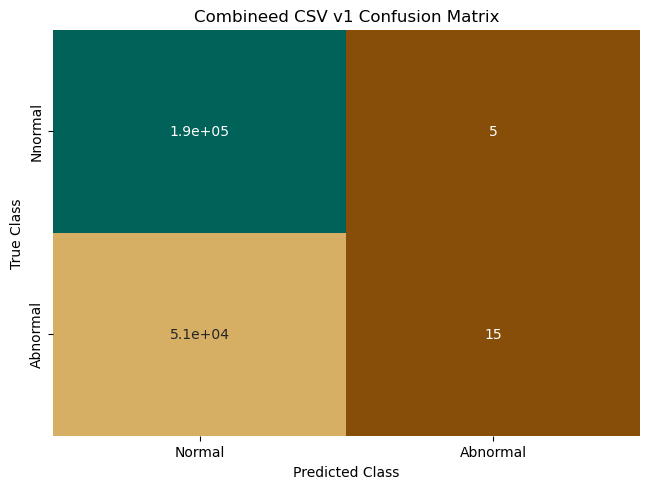

In [29]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Combineed CSV v1 Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [30]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
print("confusion matrix metrics")
print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

Sensitivity  = float(TP)/(TP+FN)*100
Specificity  = float(TN)/(TN+FP)*100
Precision = float(TP)/(TP+FP)*100
NPV = float(TN)/(TN+FN)*100
FPR = float(FP)/(FP+TN)*100
FNR = float(FN)/(TP+FN)*100
FDR = float(FP)/(TP+FP)*100
ACC = float(TP+TN)/(TP+FP+FN+TN)*100

print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

confusion matrix metrics
True Negative (TN) : 193833
False Positive (FP): 5
False Negative (FN): 51485
True Positive (TP) : 15
Sensitivity or TPR: 0.02912621359223301%
Specificity or TNR: 99.99742052641896%
Precision: 75.0%
Negative Predictive Value: 79.01295461401119%
False Positive Rate: 0.002579473581031583%
False Negative Rate: 99.97087378640776%
False Discovery Rate: 25.0%
Accuracy: 79.01262747719473%


[       inf 0.71681511 0.69800341 ... 0.03156921 0.03125693 0.02350957]
Figure(640x480)


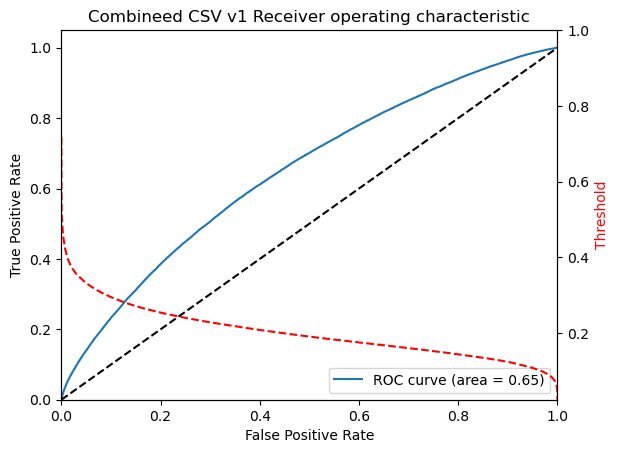

<Figure size 640x480 with 0 Axes>

In [31]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted["target"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combineed CSV v1 Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
print(thresholds)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

In [32]:
# The initial split of 70/15/15 results in a first split of 0.3 for training, followed by 0.7 for further training, and 0.3 for testing and validation. The testing and validation subset is further divided in half, resulting in a 0.15 split for each.
train_v2, test_and_validate_v2 = train_test_split(csv_v2, test_size=0.3, random_state=42, stratify=csv_v2['target'])
test_v2, validate_v2 = train_test_split(test_and_validate_v2, test_size=0.5, random_state=42, stratify=test_and_validate_v2['target'])
print("#########")
print("combined_csv_v2 train, test and validate data")
print("train.shape")
print(train_v2.shape)
print("test.shape")
print(test_v2.shape)
print("validate.shape")
print(validate_v2.shape)
print("train target")
print(train_v2['target'].value_counts())
print("test target")
print(test_v2['target'].value_counts())
print("validate target")
print(validate_v2['target'].value_counts())

#########
combined_csv_v2 train, test and validate data
train.shape
(1144913, 86)
test.shape
(245338, 86)
validate.shape
(245339, 86)
train target
target
0    904581
1    240332
Name: count, dtype: int64
test target
target
0    193838
1     51500
Name: count, dtype: int64
validate target
target
0    193839
1     51500
Name: count, dtype: int64


In [40]:
train_file_v2='combined_csv_v2_train.csv'
test_file_v2='combined_csv_v2_test.csv'
validate_file_v2='combined_csv_v2_validate.csv'

upload_data_s3(train_file_v2, 'train', train_v2, bucket, prefix, "v2")
upload_data_s3(test_file_v2, 'test', test_v2, bucket, prefix, "v2")
upload_data_s3(validate_file_v2, 'validate', validate_v2, bucket, prefix, "v2")

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Uploaded train to s3 v2


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Uploaded test to s3 v2
Uploaded validate to s3 v2


In [41]:
container_v2 = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location_v2="s3://{}/{}/output-xgboost-v2/".format(bucket,prefix)
xgboost_estimator_v2 = sagemaker.estimator.Estimator(container_v2,
                                            sagemaker.get_execution_role(),
                                            instance_count=1,
                                            instance_type='ml.m4.xlarge',
                                            output_path=s3_output_location_v2,
                                            hyperparameters=hyperparams,
                                            sagemaker_session=sagemaker.Session())

train_trainingInput_v2 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file_v2),
    content_type='text/csv')

validate_trainingInput_v2 = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file_v2),
    content_type='text/csv')

data_channels = {'train': train_trainingInput_v2, 'validation': validate_trainingInput_v2}

xgboost_estimator_v2.fit(inputs=data_channels, logs=False)

print('ready xgboost v2!')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-03-01-37-03-917



2023-11-03 01:37:04 Starting - Starting the training job.....
2023-11-03 01:37:38 Starting - Preparing the instances for training..............
2023-11-03 01:38:50 Downloading - Downloading input data.......
2023-11-03 01:39:30 Training - Downloading the training image.......
2023-11-03 01:40:11 Training - Training image download completed. Training in progress............................................
2023-11-03 01:43:55 Uploading - Uploading generated training model.
2023-11-03 01:44:07 Completed - Training job completed
ready xgboost v2!


In [43]:
xgb_predictor_v2 = xgboost_estimator_v2.deploy(initial_instance_count=1,
                                  serializer = sagemaker.serializers.CSVSerializer(),
                                  instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-03-01-45-21-726
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-03-01-45-21-726
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-03-01-45-21-726


------!

In [44]:
row = test_v2.iloc[0:1,1:]
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

2296.0,8,42,0,157.0,13,0,239.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1



In [45]:
xgb_predictor_v2.predict(test_row)

b'0.09078147262334824'

In [ ]:
batch_X = test_v2.iloc[:,1:];
batch_X_xgboost_v2_file='batch-in-xgboost-v2.csv'
upload_data_s3(batch_X_xgboost_v2_file, 'batch-in-xgboost', batch_X, bucket, prefix, "v2")
batch_output_xgboost = "s3://{}/{}/batch-out-xgboost/".format(bucket,prefix)
batch_input_xgboost = "s3://{}/{}/batch-in-xgboost/{}".format(bucket,prefix,batch_X_xgboost_v2_file)

xgb_transformer_v2 = xgboost_estimator_v2.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output_xgboost)

xgb_transformer_v2.transform(data=batch_input_xgboost,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v2.wait()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-03-01-50-10-574


Uploaded batch-in-xgboost to s3 v2


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-03-01-50-11-219


In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out-xgboost/{}".format(prefix,f"{batch_X_xgboost_v2_file}.out"))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
target_predicted_binary = target_predicted['target'].apply(binary_convert)
target_predicted_binary.head(5)


In [ ]:
test_labels = test_v2.iloc[:,0]
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Combineed CSV v2 Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100

# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100

# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100

# Negative predictive value
NPV = float(TN)/(TN+FN)*100

# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100

# False negative rate
FNR = float(FN)/(TP+FN)*100

# False discovery rate
FDR = float(FP)/(TP+FP)*100

# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100


print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 


In [ ]:
test_labels = test_v2.iloc[:,0]
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted["target"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combineed CSV v1 Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
print(thresholds)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

Step 3.6. write down your observation on the difference between the performance of using the simple and ensemble models.

In [ ]:
# Write the final comments here and turn the cell type into markdown